# Data Cleaning on Online Sales Data

The [dataset](https://www.kaggle.com/datasets/arnavsmayan/online-retail-sales-dataset) will provide synthetic data for online retail sales, which include details of customer transactions and orders with regard to the involved items, their quantities, prices, discounts, methods of payment, and the customers' demographics for analysis in terms of buying behavior, sales trend, inventory management, and marketing strategy.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
import statsmodels.api as sm
from scipy.stats import shapiro, normaltest, levene, zscore, boxcox, stats
import statsmodels.api as sm
import re

In [2]:
# Set visual display settings
sns.set(style='whitegrid')

## Load CSV

In [3]:
original_df = pd.read_csv('online_retail_sales_dataset.csv')

In [4]:
# Vars

# specify numeric columns
numeric_columns = original_df.select_dtypes(include=['int64', 'float64']).columns

# specify columns to eliminate
columns_to_exclude = ['transaction_id', 'customer_id', 'product_id']

# columns for usual numeric process
cols_to_process = ['quantity', 'price', 'discount', 'customer_age', 'total_amount']

# filter out the specified numeric columns
filtered_numeric_columns = [col for col in numeric_columns if col not in columns_to_exclude]

# DF of numeric columns to process
filtered_numeric_df = original_df[filtered_numeric_columns]

# Create a copy of the original DataFrame
original_df_copy = original_df.copy()

In [5]:
# View first 5 rows
original_df.head()

,transaction_id,timestamp,customer_id,product_id,product_category,quantity,price,discount,payment_method,customer_age,customer_gender,customer_location,total_amount
0,1,2023-01-01 00:00:00,1993,915,Home & Kitchen,8,103.30,0.23,Gift Card,27,Female,North America,636.33
1,2,2023-01-01 00:01:00,3474,553,Clothing,9,180.28,0.31,Gift Card,53,Other,South America,1119.54
2,3,2023-01-01 00:02:00,4564,248,Beauty & Personal Care,7,81.58,0.27,Debit Card,34,Other,North America,416.87
3,4,2023-01-01 00:03:00,1133,948,Clothing,3,235.20,0.00,Debit Card,50,Other,Australia,705.60
4,5,2023-01-01 00:04:00,3626,284,Books,9,453.00,0.34,Credit Card,23,Female,Australia,2690.82


## DF Overview

In [6]:
# Check datatypes of the column 
original_df.info()
# there are 8 numeric & 5 non-numeric cols

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   transaction_id     1000000 non-null  int64  
 1   timestamp          1000000 non-null  object 
 2   customer_id        1000000 non-null  int64  
 3   product_id         1000000 non-null  int64  
 4   product_category   1000000 non-null  object 
 5   quantity           1000000 non-null  int64  
 6   price              1000000 non-null  float64
 7   discount           1000000 non-null  float64
 8   payment_method     1000000 non-null  object 
 9   customer_age       1000000 non-null  int64  
 10  customer_gender    1000000 non-null  object 
 11  customer_location  1000000 non-null  object 
 12  total_amount       1000000 non-null  float64
dtypes: float64(3), int64(5), object(5)
memory usage: 99.2+ MB


In [7]:
# Columns included
original_df.columns

Index(['transaction_id', 'timestamp', 'customer_id', 'product_id',
       'product_category', 'quantity', 'price', 'discount', 'payment_method',
       'customer_age', 'customer_gender', 'customer_location', 'total_amount'],
      dtype='object')

In [8]:
# Shape of DF (rows, columns)
original_df.shape

(1000000, 13)

### Descriptive Statistics of Numeric Columns

In [9]:
original_df[cols_to_process].describe()

,quantity,price,discount,customer_age,total_amount
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,5.003086,252.445705,0.250204,43.508625,946.839858
std,2.581004,142.868633,0.144384,15.007346,810.902205
min,1.000000,5.000000,0.000000,18.000000,2.560000
25%,3.000000,128.690000,0.130000,31.000000,297.180000
50%,5.000000,252.700000,0.250000,44.000000,715.710000
75%,7.000000,375.990000,0.380000,57.000000,1397.750000
max,9.000000,500.000000,0.500000,69.000000,4496.130000


## Data Cleaning

[Explicitly defining data types for your columns ensures consistency, prevents implicit conversions, enhances performance, and avoids errors during analysis](https://www.geeksforgeeks.org/explicitly-define-datatype-in-a-python-function/). This practice is crucial for large datasets or collaborative work. However, if you're confident in your data's structure or only conducting exploratory analysis, explicit type definitions may not be necessary.

### Standardizing Format: Type Conversion

Type Conversion Applied To All Columns: transaction_id', 'timestamp', 'customer_id', 'product_id', 'product_category', 'quantity', 'price', 'discount', 'payment_method', 'customer_age', 'customer_gender', 'customer_location', 'total_amount'

Strategy/Action Taken: In our aim to standardize formats within the dataset, specific type conversions were executed to maintain consistency across pertinent columns. For example, the price column was transformed into the float64 data type using the command original_df['price'] = original_df['price'].astype('float64'). Likewise, the customer_location column was converted to a string data type with original_df['customer_location'] = original_df['customer_location'].astype(str), and the quantity column was cast to the int64 type through original_df['quantity'] = original_df['quantity'].astype('int64').

While utilizing df.info() to examine data types is a useful initial step in recognizing the data types present in the DataFrame, it does not ensure that all entries are accurately formatted or suitable for analysis. For instance, a column identified as int64 by df.info() may still include non-integer entries or NaN values that could hinder analytical processes. Therefore, explicit type conversion is essential to confirm data integrity and usability.

The convert_column_types function takes a DataFrame and a dictionary of column types as input, and returns the DataFrame with the columns converted to their respective data types. The function supports the following data types: int64: Converts the column to int64 type using pd.to_numeric with errors='coerce' to handle non-numeric values, and then fills missing values with 0 using fillna(0). object: Converts the column to object type using astype(str). float64: Converts the column to float64 type using pd.to_numeric with errors='coerce' to handle non-numeric values, and then fills missing values with 0.0 using fillna(0.0). datetime64[ns]: Converts the column to datetime64[ns] type using pd.to_datetime with errors='coerce' to handle non-date values. The confirm_column_types function takes a DataFrame and a dictionary of column types as input, and returns True if all columns have the expected data types, False otherwise. You can use these functions to convert and confirm the data types of your DataFrame.

**Rationale**: Maintaining consistent data types mitigates errors during analysis by ensuring that operations conducted on the data are valid. For instance, performing numerical operations on a column containing string data would lead to errors, while calculations dependent on specific data types could produce incorrect results if formats are inconsistent. By executing these type conversions, potential risks associated with data analysis—such as runtime errors, misinterpretations, and inaccurate modeling outcomes—are significantly diminished. This proactive strategy not only protects data quality but also improves the overall reliability of the insights obtained from subsequent analyses. Standardization is particularly crucial when integrating multiple datasets, as varying formats can result in significant challenges during merging or joining operations.

In [10]:
def convert_column_types(df, column_types):
    for column, data_type in column_types.items():
        if data_type == 'int64':
            df[column] = pd.to_numeric(df[column], errors='coerce').fillna(0).astype(np.int64)
        elif data_type == 'object':
            df[column] = df[column].astype(str)
        elif data_type == 'float64':
            df[column] = pd.to_numeric(df[column], errors='coerce').fillna(0.0).astype(np.float64)
        elif data_type == 'datetime64[ns]':
            df[column] = pd.to_datetime(df[column], errors='coerce')
        else:
            raise ValueError(f"Unsupported data type: {data_type}")
    return df

def confirm_column_types(df, column_types):
    for column, data_type in column_types.items():
        if df[column].dtype != data_type:
            return False
    return True

column_types = {
   'transaction_id': 'int64', 'timestamp': 'object', 'customer_id': 'int64', 'product_id': 'int64',
       'product_category': 'object', 'quantity': 'int64', 'price': 'float64', 'discount': 'float64', 'payment_method': 'object',
       'customer_age': 'int64', 'customer_gender': 'object', 'customer_location': 'object', 'total_amount': 'float64'
}

# Apply the function to new DF
### First conversion ###
dataType_converted_df = convert_column_types(original_df_copy, column_types)
print(dataType_converted_df.dtypes)

transaction_id         int64
timestamp             object
customer_id            int64
product_id             int64
product_category      object
quantity               int64
price                float64
discount             float64
payment_method        object
customer_age           int64
customer_gender       object
customer_location     object
total_amount         float64
dtype: object


### Validation for Type Conversion

In [11]:
# Confirm the columns of a DataFrame have the expected data types.

if confirm_column_types(dataType_converted_df, column_types):
    print("All columns have the expected data types.")
else:
    print("Not all columns have the expected data types.")

All columns have the expected data types.


In [12]:
# Check for duplicate rows
# Ensure that there are no duplicate entries in the dataset, particularly after any transformation.
duplicate_rows = dataType_converted_df[dataType_converted_df.duplicated()]
print(duplicate_rows)

Empty DataFrame
Columns: [transaction_id, timestamp, customer_id, product_id, product_category, quantity, price, discount, payment_method, customer_age, customer_gender, customer_location, total_amount]
Index: []


In [13]:
# Check for negative prices
# For numerical columns, it's important to perform checks to ensure that the data falls within expected ranges.
negative_prices = dataType_converted_df[dataType_converted_df['price'] < 0]
print(negative_prices)

Empty DataFrame
Columns: [transaction_id, timestamp, customer_id, product_id, product_category, quantity, price, discount, payment_method, customer_age, customer_gender, customer_location, total_amount]
Index: []


## Standardizing Format: Standardizing Categorical Columns to Lower Case

Applied To Columns: 'timestamp', 'product_category', 'payment_method', 'customer_gender', 'customer_location'

Action Taken: The function convert_object_columns_to_lower_case takes a DataFrame as input and returns the DataFrame with all categorical columns converted to lower case. The function uses the select_dtypes method to select the columns with datatype object, and then applies the map method to convert the values in these columns to lower case. The map method applies a function to each element in the DataFrame. In this case, the function checks if the element is a string using isinstance(x, str), and if it is, converts it to lower case using x.lower().

**Rationale**: Converting categorical columns to lowercase during data cleaning is crucial for ensuring consistency, improving data quality, enhancing processing performance, and facilitating compatibility with analytical tools. By standardizing entries to the same format, it eliminates discrepancies from variations in capitalization, which aids in accurate data aggregation and analysis. Additionally, lowercasing reduces the likelihood of errors during data processing—particularly in operations like grouping or merging—by preventing missed matches or duplicates. It also improves the efficiency of string operations in data processing frameworks, especially with large datasets. Finally, this conversion ensures that machine learning algorithms can effectively encode and analyze categorical data, as many require consistent formats for accurate recognition and transformation.

In [14]:
# Filter columns with datatype object
object_columns = dataType_converted_df.select_dtypes(include=['object'])
object_columns.columns

Index(['timestamp', 'product_category', 'payment_method', 'customer_gender',
       'customer_location'],
      dtype='object')

In [15]:
# Convert all categorical columns (object type) to lower case in a pandas DataFrame
def convert_object_columns_to_lower_case(df):
    object_columns = df.select_dtypes(include=['object']).columns
    df[object_columns] = df[object_columns].map(lambda x: x.lower() if isinstance(x, str) else x)
    return df

print(f"Before conversion: {original_df['payment_method'].unique()}")

Before conversion: ['Gift Card' 'Debit Card' 'Credit Card' 'PayPal']


In [16]:
# Convert DF categorical column to lowercase
### Second conversion ###
dataType_converted_df_copy = dataType_converted_df.copy()
lowercase_converted_df = convert_object_columns_to_lower_case(dataType_converted_df_copy)

print(f"After conversion: {lowercase_converted_df['payment_method'].unique()}")

After conversion: ['gift card' 'debit card' 'credit card' 'paypal']


### Validation for Converting Categorical Columns to Lowercase

In [17]:
# Check for unique values within these columns to validate
print(f"Before conversion: {original_df['payment_method'].unique()}")
print(f"After conversion: {lowercase_converted_df['customer_location'].unique()}")

Before conversion: ['Gift Card' 'Debit Card' 'Credit Card' 'PayPal']
After conversion: ['north america' 'south america' 'australia' 'asia' 'europe' 'africa']


## Standardizing Format: Timestamp Conversion To DateTime Object With ISO 8601 Format

In the Philippines, the recommended timestamp format conforms to the ISO 8601 standard, which prescribes the format as YYYY-MM-DD for dates and utilizes the 24-hour clock format for times, resulting in a complete representation such as 2023-01-01T00:02:00. This standardization enhances clarity and mitigates ambiguity in datetime notation, making it appropriate for legal and technical applications.

Applied To Column: 'timestamp'

StrategyAction Taken: To convert a timestamp column in a dataset to the ISO 8601 format using pd.to_datetime, we utilized the to_datetime() function from the Pandas library along with dt.strftime(). After conversion, a validation methods can help ensure that the resulting dates are correct and in the desired format.

**Rationale**: Correct data types minimize the risk of errors during computations and support the correct functioning of analysis functions.

In [18]:
# ISO 8601 utilizes without the 24-hour clock format for times
### Third Conversion ###
# Convert timestamp column to datetime
datetime_converted_df = lowercase_converted_df.copy() 
datetime_converted_df['timestamp'] = pd.to_datetime(datetime_converted_df['timestamp']).dt.strftime('%Y-%m-%d')
# ISO 8601 with date  only
datetime_converted_df.head()

,transaction_id,timestamp,customer_id,product_id,product_category,quantity,price,discount,payment_method,customer_age,customer_gender,customer_location,total_amount
0,1,2023-01-01,1993,915,home & kitchen,8,103.30,0.23,gift card,27,female,north america,636.33
1,2,2023-01-01,3474,553,clothing,9,180.28,0.31,gift card,53,other,south america,1119.54
2,3,2023-01-01,4564,248,beauty & personal care,7,81.58,0.27,debit card,34,other,north america,416.87
3,4,2023-01-01,1133,948,clothing,3,235.20,0.00,debit card,50,other,australia,705.60
4,5,2023-01-01,3626,284,books,9,453.00,0.34,credit card,23,female,australia,2690.82


### Validation for Datetime Object Conversion

In [19]:
# Check data types
print(f"Before datetime conversion: {original_df.dtypes}")
print(f"After datetime conversion: {datetime_converted_df.dtypes}")

Before datetime conversion: transaction_id         int64
timestamp             object
customer_id            int64
product_id             int64
product_category      object
quantity               int64
price                float64
discount             float64
payment_method        object
customer_age           int64
customer_gender       object
customer_location     object
total_amount         float64
dtype: object
After datetime conversion: transaction_id         int64
timestamp             object
customer_id            int64
product_id             int64
product_category      object
quantity               int64
price                float64
discount             float64
payment_method        object
customer_age           int64
customer_gender       object
customer_location     object
total_amount         float64
dtype: object


In [20]:
# Function to verify the format
def validate_date_format(date_str):
    pattern = r'^\d{4}-\d{2}-\d{2}$'  # YYYY-MM-DD format
    return bool(re.match(pattern, date_str))

# Validate all entries in the converted timestamp column
datetime_converted_df['Is_Valid'] = datetime_converted_df['timestamp'].apply(validate_date_format)

# Print the validation results
print(datetime_converted_df[['timestamp', 'Is_Valid']])
print(f"Valid Date Format: {datetime_converted_df['Is_Valid'].unique()}")

         timestamp  Is_Valid
0       2023-01-01      True
1       2023-01-01      True
2       2023-01-01      True
3       2023-01-01      True
4       2023-01-01      True
...            ...       ...
999995  2024-11-25      True
999996  2024-11-25      True
999997  2024-11-25      True
999998  2024-11-25      True
999999  2024-11-25      True

[1000000 rows x 2 columns]
Valid Date Format: [ True]


In [21]:
# Drop IS_Valid Column
datetime_converted_df = datetime_converted_df.drop('Is_Valid', axis=1)

### Handling Missisng Values

Strategy: The first step was to use the Pandas library to find and count missing values with th e method original_df.isnull().sum(). This was important for understanding how much data was missing, which helped in deciding how to handle it. The goal was to either remove incomplete records or fill in the gaps using imputation methods.

Action Taken: Mean/Median Imputation: In case of numerical datasets, missing values may also be handled by replacing them with the mean or median of that column. This would be very efficient if the data comes in a normal distribution. This approach will not reduce the overall size of the dataset. However, if the missing data is not random, it introduces some bias.

Mode Imputation: For categorical data files, the best way of handling missing values is to take the mode that presents the most common value. This method limits any distortion of the data distribution.These steps helped keep the dataset strong for future analysis without bias from missing data.

**Rationale**: Choosing to fill in some missing values instead of removing them was aimed at preserving useful information and keeping the sample size large, especially when the amount of missing data was small. This balance between keeping data and ensuring accuracy is crucial, particularly when each observation can greatly affect model results. Handling missing values ensures comprehensive datasets, reducing biases during analysis. This practice allows for better data integrity and improved predictive performance.

In [22]:
# Identify columns with missing values
# Check for missing values in the original DataFrame
original_df.isnull().sum()
# DF has no NAN

transaction_id       0
timestamp            0
customer_id          0
product_id           0
product_category     0
quantity             0
price                0
discount             0
payment_method       0
customer_age         0
customer_gender      0
customer_location    0
total_amount         0
dtype: int64

Suggestions if missing values are present

For numeric column:

df['col'] = df['col'].fillna(0)

Option to fill missing values in a specific column with the mean:

df['price'].fillna(df['price'].mean(), inplace=True) For non-numeric columns replace with appropriate string:

df['col'] = df['col'].fillna('blah!')

Option to fill missing values in a specific column with the mean:

df['price'].fillna(df['price'].mean(), inplace=True)

### Validation for Handling Missing Values

In [23]:
original_df['price'] = original_df['price'].fillna(0)
# Check for missing values in the cleaned DataFrame
original_df.isnull().sum()

transaction_id       0
timestamp            0
customer_id          0
product_id           0
product_category     0
quantity             0
price                0
discount             0
payment_method       0
customer_age         0
customer_gender      0
customer_location    0
total_amount         0
dtype: int64

In [24]:
# Summation of duplicated rows
original_df.duplicated().sum()

np.int64(0)

## Handling Duplicate Rows

Suggestion if there are duplicate rows

Remove duplicate rows

```
original_df = original_df.drop_duplicates()
```

**Rationale**: By eliminating duplicates, data clarity is enhanced, allowing for more accurate insights from analyses.

In [25]:
print(f"Shape of DF before handling of duplicate rows: : {original_df.shape}")

Shape of DF before handling of duplicate rows: : (1000000, 13)


In [26]:
# remove duplicate rows
original_df = original_df.drop_duplicates()

### Validation for Handling Duplicate Rows

In [27]:
# check for duplicate rows
print(f"Number of deleted rows due to duplication: {original_df.duplicated().sum()}")
print(f"Shape of DF after handling of duplicate rows: : {original_df.shape}")

Number of deleted rows due to duplication: 0
Shape of DF after handling of duplicate rows: : (1000000, 13)


## Outliers Elimination

​Outliers can significantly skew analyses and lead to misleading results in statistical calculations.​ The Interquartile Range (IQR) method is one effective approach for identifying and removing outliers. The IQR is then calculated as the difference between Q3 and Q1. We then calculate the lower and upper bounds for the dataset by subtracting and adding 1.5 times the IQR to Q1 and Q3, respectively. Any data points that fall outside of these bounds are considered outliers and are removed from the dataset. Note that the multiplier of 1.5 is a common choice for the IQR method, but you can adjust this value depending on your specific needs.

Strategy: We used IQR method that helps to detect potential outliers by focusing on the interquartile range, which captures the middle 50% of the data. It starts by calculating the first quartile (Q1) and third quartile (Q3) of the dataset.

The IQR is computed by subtracting Q1 from Q3.
Establish the lower and upper bounds for identifying outliers.
Remove the data entries that fall outside the determined bounds.
Definition of Quartiles:

Q1 (First Quartile): This is the 25th percentile of the data, meaning that 25% of the data points are below this value.
Q3 (Third Quartile): This is the 75th percentile, indicating that 75% of the data points are below this value.
Calculating IQR:

The Interquartile Range (IQR) is calculated as:
```
IQR = Q3 - Q1
```
The IQR represents the range within which the central 50% of the data points lie.
Identifying Outliers:

- Outliers are defined as any data points that fall below Q1 − 1.5 * IQR or above Q3 + 1.5 * IQR.
- Once outliers are identified, they can be removed from the dataset to ensure that subsequent analyses are not skewed by these extreme values.
- 
**Rationale**: Outliers can misrepresent the true characteristics of the dataset. The reasons for removing outliers include:

- Skewing of Results: Outliers can distort key statistics like the mean and standard deviation. For example, a single extreme value can significantly increase the mean, rendering it unrepresentative of the data as a whole.
- Impact on Statistical Tests: Many statistical tests, like t-tests or ANOVA, assume normally distributed data. Outliers can violate this assumption and lead to incorrect conclusions.
- Indication of Errors
- Outliers emerge due to data entry errors or inconsistencies in data collection methods. Removing such outliers enhances data integrity.

In [28]:
def count_outliers_iqr(dataframe, columns):
    outlier_counts = {}
    for column in columns:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = dataframe[column].quantile(0.25)
        Q3 = dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define the outlier boundaries
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Count the outliers
        outliers = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]
        outlier_counts[column] = outliers.shape[0]  # Number of outliers
    
    return outlier_counts

# Count outliers in the specified numeric columns
outlier_counts = count_outliers_iqr(datetime_converted_df, cols_to_process)

print(f"Number of outliers in total_amount column: {outlier_counts}")

Number of outliers in total_amount column: {'quantity': 0, 'price': 0, 'discount': 0, 'customer_age': 0, 'total_amount': 21985}


### Visualizing the Data Distribution

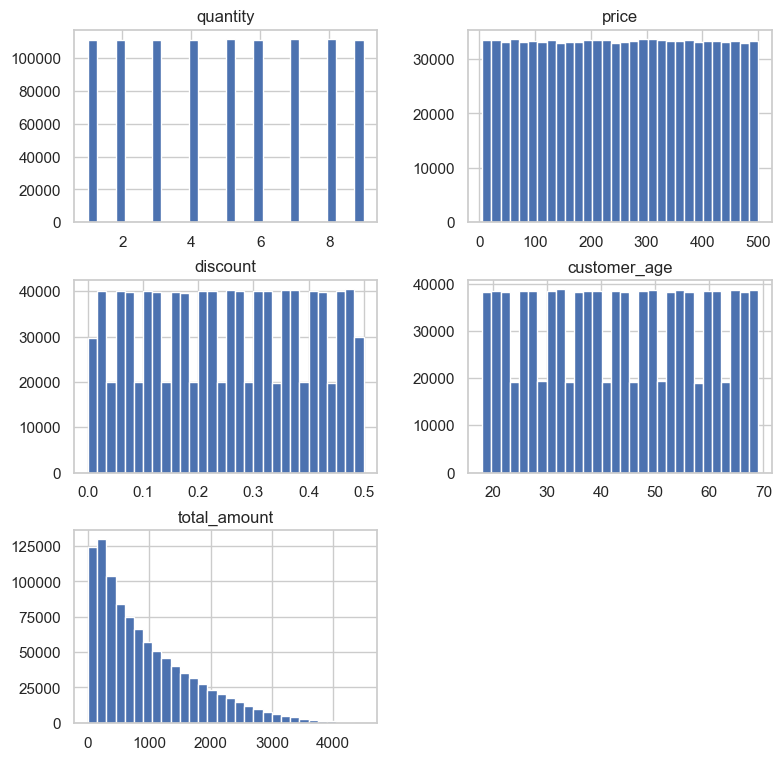

In [29]:
# Histogram for all numerical features
datetime_converted_df[cols_to_process].hist(figsize=(9, 9), bins=30)
plt.title('Distribution of Numerical Features')
plt.show()

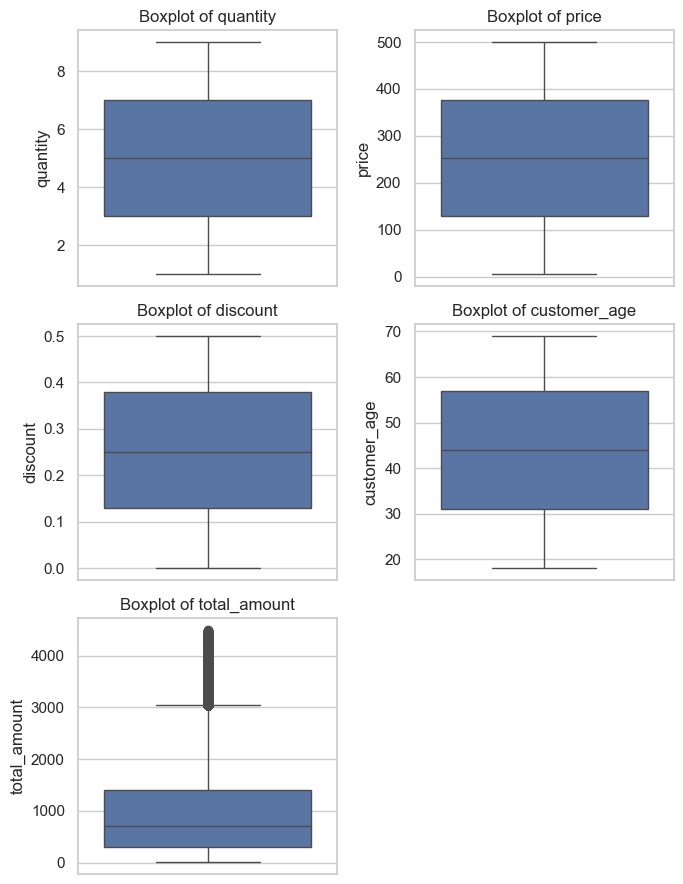

In [30]:
# Boxplot for a specific numerical column
# Set overall figure size for the plots
ncols = 2  # Number of columns
nrows = (len(cols_to_process) + ncols - 1) // ncols  # Calculate rows needed

plt.figure(figsize=(7, nrows * 3))  # Adjust height based on the number of rows

# Create boxplots for each selected column
for i, column in enumerate(cols_to_process):
    plt.subplot(nrows, ncols, i + 1)  # Adjusts the number of rows and columns for subplots
    sns.boxplot(data=datetime_converted_df[cols_to_process], y=column)
    plt.title(f'Boxplot of {column}')
    plt.tight_layout()  # Adjust layout to prevent overlap

plt.show()

In [31]:
def remove_outliers_iqr(df, numeric_columns):
    df_filtered = df.copy()

    # For each numeric column, Q1 and Q3 are calculated using quantile(), and then IQR is computed.
    
    for column in numeric_columns:
        Q1 = df_filtered[column].quantile(0.25)  # First quartile (25th percentile)
        Q3 = df_filtered[column].quantile(0.75)  # Third quartile (75th percentile)
        IQR = Q3 - Q1  # Interquartile range
        
        # Define bounds for outliers
        # The lower and upper bounds for identifying outliers are established.
        lower_bound = Q1 - 0.5 * IQR
        upper_bound = Q3 + 0.5 * IQR
        
        # Remove outliers
        # Rows containing outliers are removed based on these bounds
        df_filtered = df_filtered[(df_filtered[column] >= lower_bound) & (df_filtered[column] <= upper_bound)]

    # Cleaned DataFrame without outliers is returned
    return df_filtered


### Fourth Conversion ####
outliers_removed_df = datetime_converted_df.copy()

outliers_removed_df = remove_outliers_iqr(outliers_removed_df, cols_to_process)

# Caveat: must run this function several times to remove the outlier completely

outlier_counts = count_outliers_iqr(outliers_removed_df, cols_to_process)

### Validation for Outliers Elimination

In [32]:
print(f"Number of outliers in total_amount column after deletion: {outlier_counts}")

Number of outliers in total_amount column after deletion: {'quantity': 0, 'price': 0, 'discount': 0, 'customer_age': 0, 'total_amount': 0}


In [33]:
# Descriptive Stat before Outliers Removal
original_df[cols_to_process].describe()

,quantity,price,discount,customer_age,total_amount
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,5.003086,252.445705,0.250204,43.508625,946.839858
std,2.581004,142.868633,0.144384,15.007346,810.902205
min,1.000000,5.000000,0.000000,18.000000,2.560000
25%,3.000000,128.690000,0.130000,31.000000,297.180000
50%,5.000000,252.700000,0.250000,44.000000,715.710000
75%,7.000000,375.990000,0.380000,57.000000,1397.750000
max,9.000000,500.000000,0.500000,69.000000,4496.130000


In [34]:
# Descriptive Stat After Outliers Removal
outliers_removed_df[cols_to_process].describe()

,quantity,price,discount,customer_age,total_amount
count,827986.000000,827986.000000,827986.000000,827986.000000,827986.000000
mean,4.594532,229.008478,0.263397,43.506675,704.960742
std,2.480207,136.405830,0.142579,14.429160,522.298926
min,1.000000,5.040000,0.010000,19.000000,2.560000
25%,2.000000,112.640000,0.140000,31.000000,257.500000
50%,4.000000,220.470000,0.270000,44.000000,586.690000
75%,7.000000,338.000000,0.390000,56.000000,1082.650000
max,9.000000,499.640000,0.500000,68.000000,1940.700000


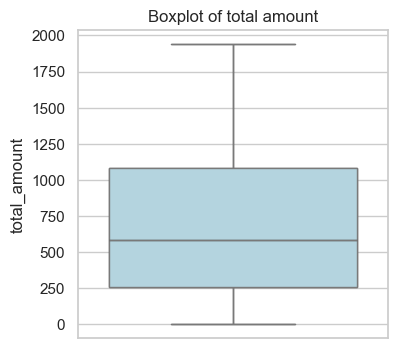

In [35]:
# Boxplot to confirm the removal of outlier
plt.figure(figsize=(4,4))
sns.boxplot(y='total_amount', data=outliers_removed_df[cols_to_process]) 
sns.boxplot(y='total_amount', data=outliers_removed_df[cols_to_process], color='lightblue')
plt.title('Boxplot of total amount')
plt.show()

## Sampling

**Sample Size Considerations**

A sample of 358 is sometimes considered standard due to statistical guidelines that help balance accuracy and practicality. This number can provide a reasonable assurance of representing the population well while allowing for sufficient power in statistical tests. Depending on the specific research goals, using a n=358 can yield very reliable data while still being manageable in scale. Therefore, our group will choose an n=1000 for given N=1000000.

In [36]:
# Sample size calculation
### Fifth Conversion ###
sampled_df = outliers_removed_df.copy()
sampled_df = sampled_df.sample(n=1000, random_state=42)  # random_state is optional for reproducibility

In [37]:
print("Shape before sampling:", original_df.shape)
print("Shape after sampling:", sampled_df.shape)

Shape before sampling: (1000000, 13)
Shape after sampling: (1000, 13)


## Test For Normality

Outliers can indeed affect the distribution of a dataset, but they don't necessarily cause a distribution to be non-normal or skewed. Normal Distribution: A normal distribution, also known as a Gaussian distribution or bell curve, is a symmetric distribution where the majority of the data points cluster around the mean, and the probability of extreme values decreases as you move away from the mean. Outliers can affect the normality of a distribution, but it's not a guarantee that the distribution will become non-normal.

Skewed Distribution: A skewed distribution is a distribution that is not symmetric, meaning that the majority of the data points are concentrated on one side of the distribution. Outliers can contribute to skewness, especially if they are extreme values that are far away from the mean. However, a single outlier may not be enough to cause significant skewness.

Outliers can affect the distribution in several ways:

- Asymmetry: Outliers can create asymmetry in the distribution, especially if they are extreme values that are far away from the mean.
- Skewness: Outliers can contribute to skewness, especially if they are concentrated on one side of the distribution.
- Kurtosis: Outliers can affect the kurtosis of the distribution, which measures the "tailedness" or "peakedness" of the distribution.
- Mean and Variance: Outliers can affect the mean and variance of the distribution, especially if they are extreme values.

In [38]:
# Shapiro-Wilk
def shapiroWilk(df, columns):
    for col in columns:
        stat, p = shapiro(df[col])
        print(f'Shapiro-Wilk Test for {col}: Statistics={stat}, p-value={p}')
        
        if p > 0.05:
            print(f'{col} looks Gaussian (fail to reject H0)')
        else:
            print(f'{col} does not look Gaussian (reject H0)')

testNormalityShapiro = shapiroWilk(sampled_df, cols_to_process)

print(testNormalityShapiro)

Shapiro-Wilk Test for quantity: Statistics=0.9390583288826161, p-value=8.096561040814828e-20
quantity does not look Gaussian (reject H0)
Shapiro-Wilk Test for price: Statistics=0.9578134870300791, p-value=2.2272030287211214e-16
price does not look Gaussian (reject H0)
Shapiro-Wilk Test for discount: Statistics=0.9587961033802549, p-value=3.5976536096550335e-16
discount does not look Gaussian (reject H0)
Shapiro-Wilk Test for customer_age: Statistics=0.9501792277973906, p-value=6.862099915426923e-18
customer_age does not look Gaussian (reject H0)
Shapiro-Wilk Test for total_amount: Statistics=0.929359299457608, p-value=2.6734648997653623e-21
total_amount does not look Gaussian (reject H0)
None


In [39]:
results = {}
def dagostino(df):
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        stat, p_value = normaltest(df[column])
        results[column] = {'Test Statistic': stat, 'p-value': p_value}
    
    # Display the results
    for column, result in results.items():
        print(f"Column: {column}")
        print(f"Test Statistic: {result['Test Statistic']}")
        print(f"p-value: {result['p-value']}\n")

testDA = dagostino(sampled_df)

# test Statistic: This high value suggests a significant deviation from normality.
# p-value: This extremely low p-value indicates that the null hypothesis can be rejected with high confidence.


Column: transaction_id
Test Statistic: 632.9006515469421
p-value: 3.6929184736292845e-138

Column: customer_id
Test Statistic: 996.843680063727
p-value: 3.4525916358935593e-217

Column: product_id
Test Statistic: 626.2670104093219
p-value: 1.0182316461917174e-136

Column: quantity
Test Statistic: 250.3563997970578
p-value: 4.323132331035788e-55

Column: price
Test Statistic: 367.19636669771717
p-value: 1.8379008733257957e-80

Column: discount
Test Statistic: 451.0166870653147
p-value: 1.1560344614619774e-98

Column: customer_age
Test Statistic: 945.7869716990593
p-value: 4.2166598387854213e-206

Column: total_amount
Test Statistic: 118.94993758258596
p-value: 1.4802983074480013e-26



### Visualizing Non-Normality

**Q-Q Plot**: It compares data to a theoretical distribution (e.g., normal distribution). Deviations from the straight line indicate non-normality.

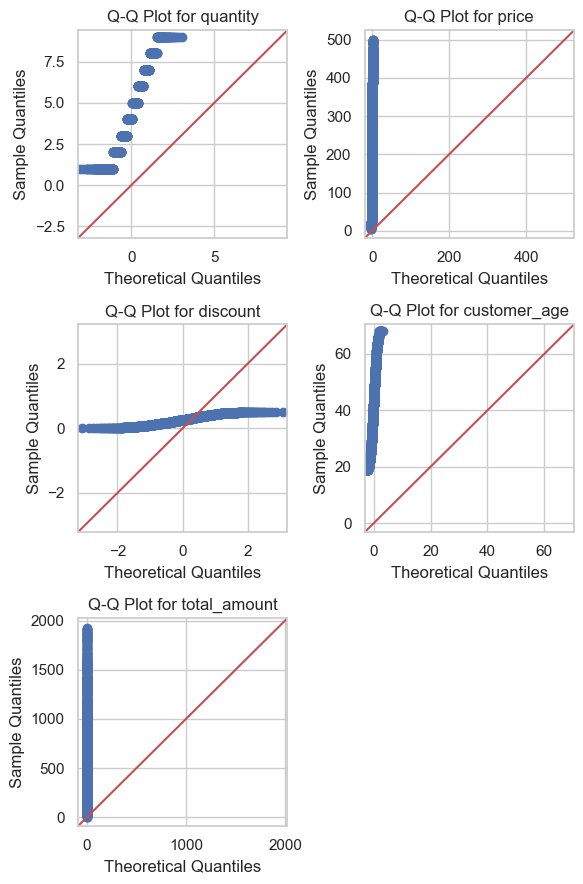

None


In [40]:
def qqplot(df):
    variables = df.columns
    # Calculate the number of rows needed
    n_vars = len(variables)
    n_cols = 2
    n_rows = (n_vars + n_cols - 1) // n_cols

    # Create a figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6, n_rows * 3))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Plot Q-Q plots for each variable
    for i, var in enumerate(variables):
        sm.qqplot(df[var], line='45', ax=axes[i])
        axes[i].set_title(f'Q-Q Plot for {var}')

    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout()
    plt.show()

print(qqplot(sampled_df[cols_to_process]))

## Data Transformation

Several methods(log, square-root, Box-Cox) can be applied to transform non-Gaussian data into a more normal-like distribution. But we used the Yeo-Johnson Transformation which imilar to Box-Cox but but can handle zero and negative values. It offers numerous benefits that enhances the efficiency and accuracy of data cleaning processes. Its ability to normalize data distributions, handle varied data types, improve model outcomes, and provide clarity in interpretation makes it an invaluable technique in the field of data analysis.

Applied To Numeric Columns: quantity', 'price', 'discount', 'customer_age', 'total_amount'

Strategy/Action Taken:

**Rationale**:

- The Yeo-Johnson transformation is useful when the data is skewed and has a non-normal distribution.
- The transformation can help to: Stabilize the variance: The transformation can help to stabilize the variance of the data, which is useful when the variance is not constant across different levels of the data.
- Make the data more normal-like: The transformation can help to make the data more normal-like, which is useful when the data is skewed or has a non-normal distribution.
- Improve the accuracy of statistical models: By making the data more normal-like, the transformation can improve the accuracy of statistical models that assume normality.

In [41]:
# Instantiate the Yeo-Johnson transformer
pt = PowerTransformer(method='yeo-johnson')

## transform_df = outliers_removed_df.copy()

outliers_removed_df[cols_to_process] = pt.fit_transform(outliers_removed_df[cols_to_process])


In [42]:
outliers_removed_df.head()

,transaction_id,timestamp,customer_id,product_id,product_category,quantity,price,discount,payment_method,customer_age,customer_gender,customer_location,total_amount
0,1,2023-01-01,1993,915,home & kitchen,1.291028,-0.859614,-0.248139,gift card,-1.151753,female,north america,0.121249
1,2,2023-01-01,3474,553,clothing,1.595661,-0.224355,0.314768,gift card,0.676799,other,south america,0.870609
2,3,2023-01-01,4564,248,beauty & personal care,0.970014,-1.068171,0.032205,debit card,-0.627898,other,north america,-0.338750
5,6,2023-01-01,3349,802,electronics,-1.050478,-1.425348,-0.733236,gift card,-1.075038,male,south america,-1.529069
6,7,2023-01-01,1136,971,clothing,0.629500,-1.201490,1.320503,paypal,0.999164,male,north america,-0.878201


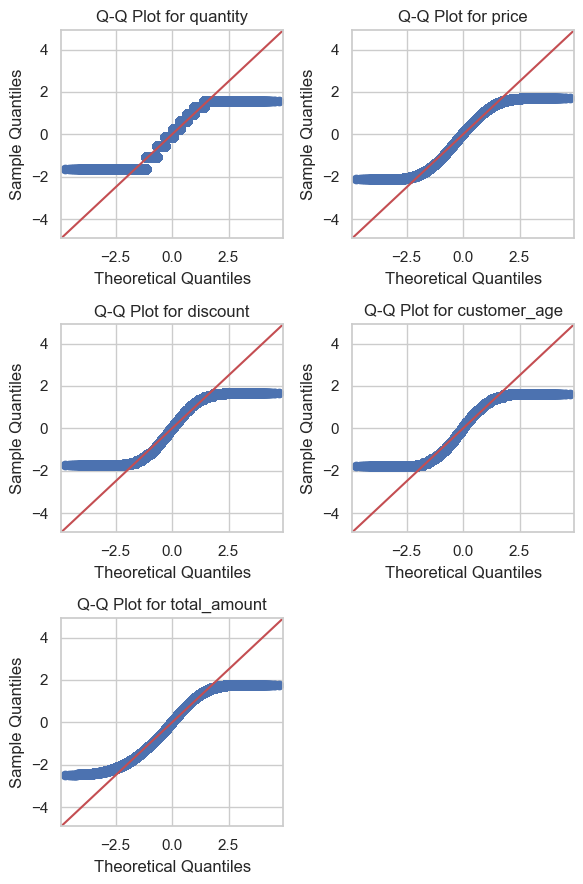

None


In [43]:
print(qqplot(outliers_removed_df[cols_to_process]))

In [44]:
sample1 = outliers_removed_df[cols_to_process].sample(n=1000, random_state=42)

In [45]:
sample1.head()

,quantity,price,discount,customer_age,total_amount
107556,1.595661,-0.311745,0.243922,-1.307316,0.795031
984285,-1.623669,-1.101549,-1.007190,-0.411763,-1.617812
80937,-1.050478,-0.309131,0.385750,1.623926,-0.866904
695100,-1.623669,1.252905,1.539283,0.676799,-0.919298
74076,-0.128931,1.501681,0.742663,1.314650,0.920206


In [46]:
testNormalityShapiro = shapiroWilk(sample1, cols_to_process)

Shapiro-Wilk Test for quantity: Statistics=0.9412707178057439, p-value=1.862864498608821e-19
quantity does not look Gaussian (reject H0)
Shapiro-Wilk Test for price: Statistics=0.9655890840046084, p-value=1.2584965545659284e-14
price does not look Gaussian (reject H0)
Shapiro-Wilk Test for discount: Statistics=0.9584051773264841, p-value=2.969964367516534e-16
discount does not look Gaussian (reject H0)
Shapiro-Wilk Test for customer_age: Statistics=0.950802005184377, p-value=8.9803664958313e-18
customer_age does not look Gaussian (reject H0)
Shapiro-Wilk Test for total_amount: Statistics=0.970973489482086, p-value=3.0192148376168984e-13
total_amount does not look Gaussian (reject H0)


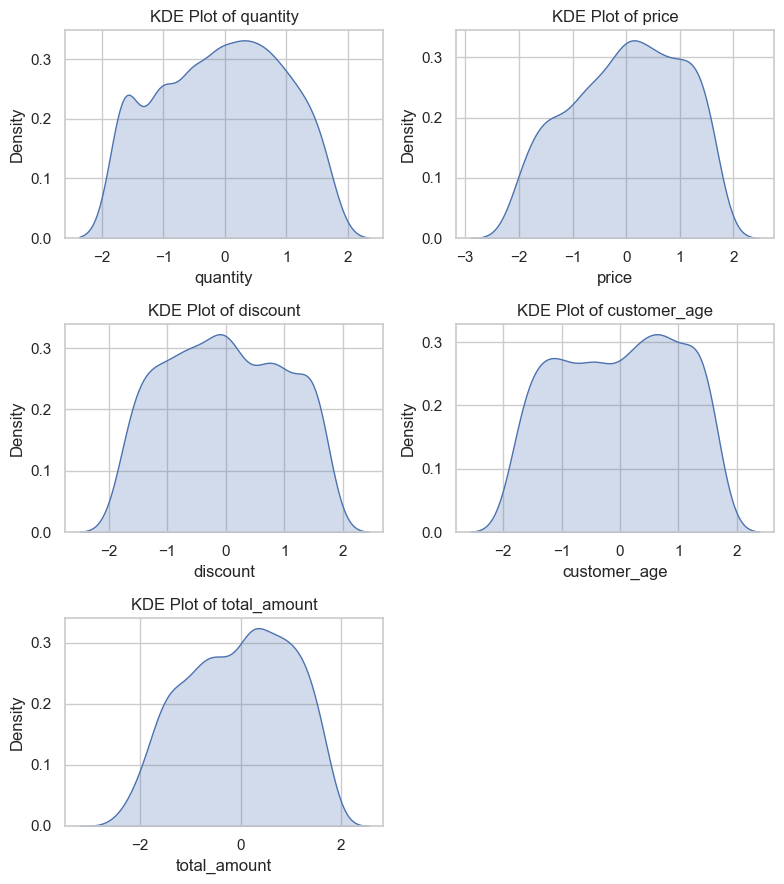

In [47]:
def histoplot(df):
    numeric_cols = df.columns
    num_plots = len(numeric_cols)
    num_cols = 2
    num_rows = (num_plots + 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, num_rows * 3))

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    # Plot KDE for each numeric column
    for i, col in enumerate(numeric_cols):
        sns.kdeplot(df[col], ax=axes[i], fill=True)
        axes[i].set_title(f'KDE Plot of {col}')

    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
        plt.tight_layout()
        plt.show()

histoplot(sample1[cols_to_process])

## Data Preprocessing

**Standardization**, also known as Z-score normalization, involves rescaling the data such that it has a mean (μ) of 0 and a standard deviation (σ) of 1.

This transformation allows the data to be centered around zero, which is particularly useful for algorithms that assume normal distribution or rely on distance metrics. Standardization, is beneficial in scenarios where the dataset contains features with different units or scales.

**Normalization**, often referred to as Min-Max scaling, rescales the features to a specific range, typically [0, 1]. In this method, the minimum and maximum values in the dataset are used to ensure that all features contribute equally to the computation.

One key difference between these two techniques is their sensitivity to outliers. Standardization is less affected by outliers since it centers the data based on the mean and standard deviation. Normalization, however, can be significantly influenced by extreme values, as it directly uses the minimum and maximum values of the dataset, which can result in skewed scales.

In [48]:
# Normalizing numerical columns
scaler = MinMaxScaler()

outliers_removed_df[cols_to_process] = scaler.fit_transform(outliers_removed_df[cols_to_process])

# Display the normalized DataFrame
outliers_removed_df[cols_to_process].head()

,quantity,price,discount,customer_age,total_amount
0,0.905374,0.330583,0.436763,0.187863,0.609537
1,1.000000,0.495875,0.600707,0.722880,0.785689
2,0.805659,0.276317,0.518412,0.341138,0.501405
5,0.178047,0.183381,0.295481,0.210310,0.221596
6,0.699888,0.241628,0.893622,0.817201,0.374596


In [49]:
sample2 = outliers_removed_df[cols_to_process].sample(n=1000, random_state=42)
sample3 = outliers_removed_df.sample(n=1000)

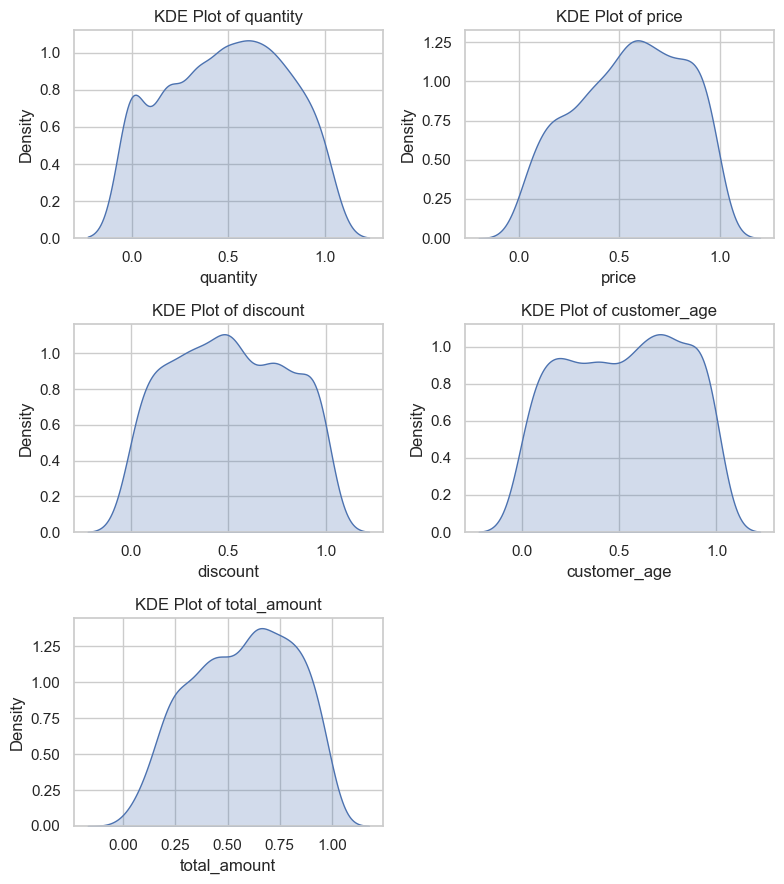

In [50]:
histoplot(sample2[cols_to_process])

Scaling data through techniques such as Standardization and Normalization is essential for various data cleaning and preparation tasks, even outside the realm of machine learning.​ These processes ensure that features are on a similar scale, which facilitates meaningful comparisons and reduces distortion in data analysis by preventing features with larger ranges from dominating those with smaller ranges. This normalization of values aids in improving interpretability by allowing patterns and relationships between variables to be more easily recognized. Additionally, scaling helps manage outlier effects and prepares data for more accurate statistical analyses, making it an indispensable step in data handling across various analytical contexts. Properly scaled data not only enhances overall data quality but also ensures that insights derived from analyses are reliable and valid.

## Additional Tests: Ad Hoc Exploratory Data Analysis & Visualization of Online Sales Data

Preliminary and non-exhaustive insights, trends and patterns that can assists in elucidating and building our Milestone 2 and TA

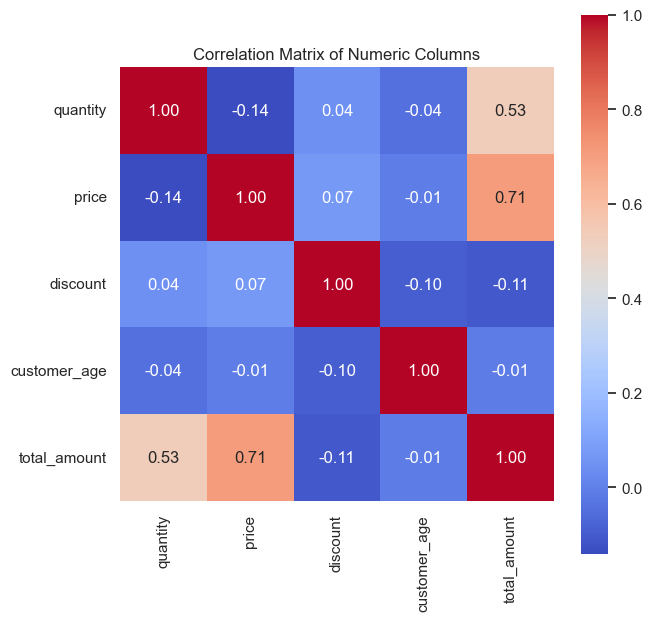

In [51]:
# Selecting numeric columns for correlation analysis
correlation_matrix = sample2.corr()

# Plotting the correlation matrix
plt.figure(figsize=(7, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix of Numeric Columns')
plt.show()

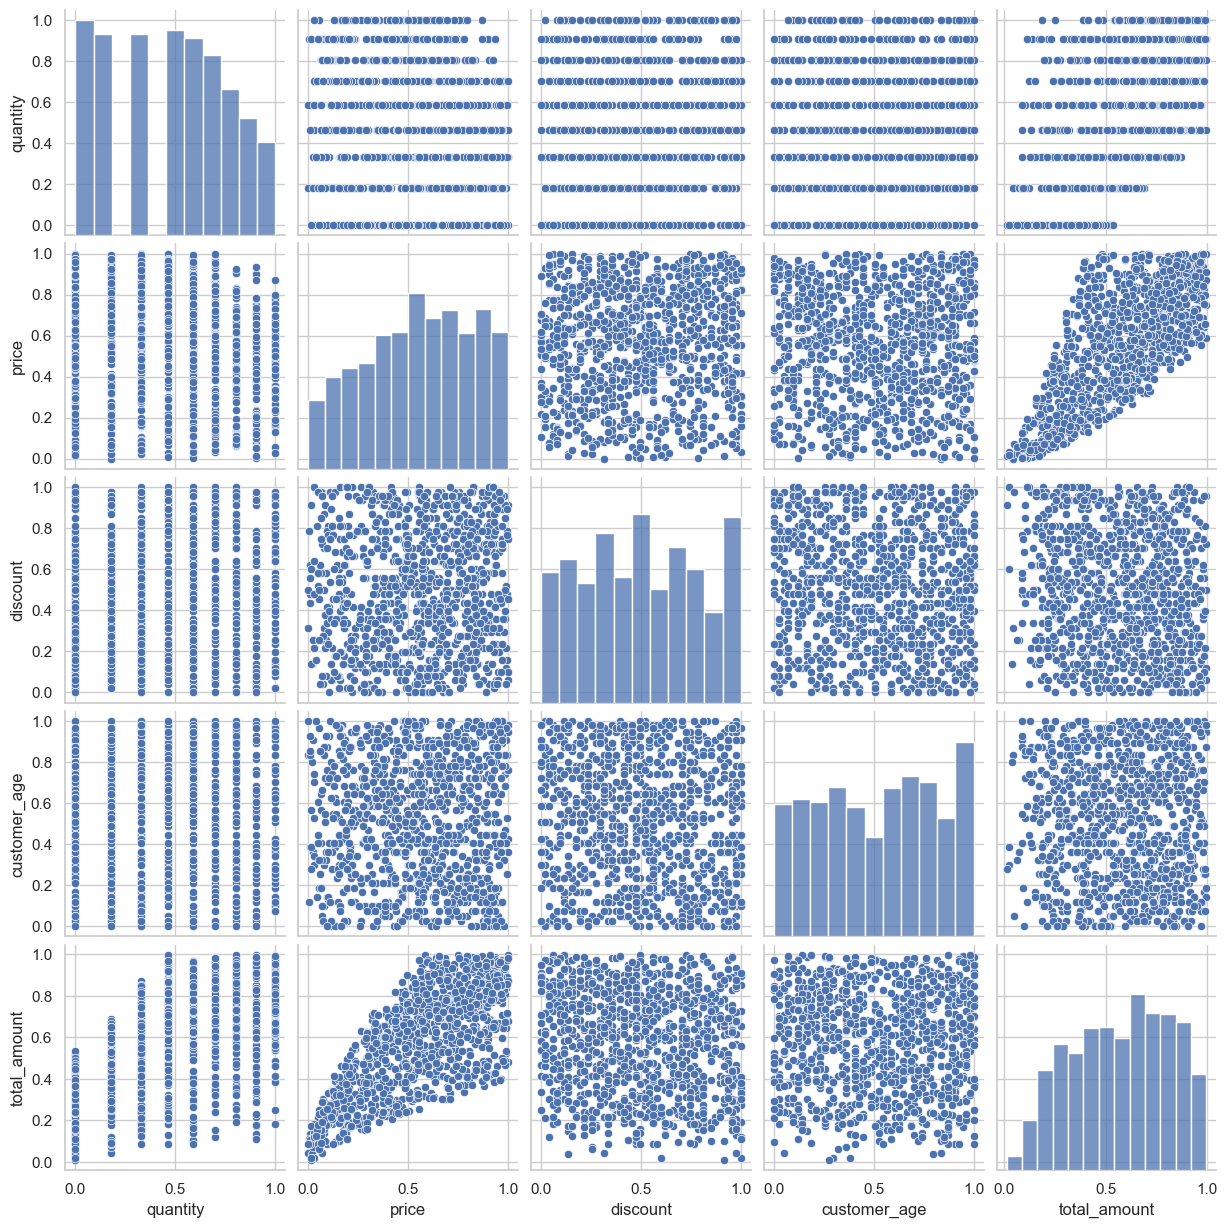

In [52]:
sns.pairplot(sample2)
plt.show()

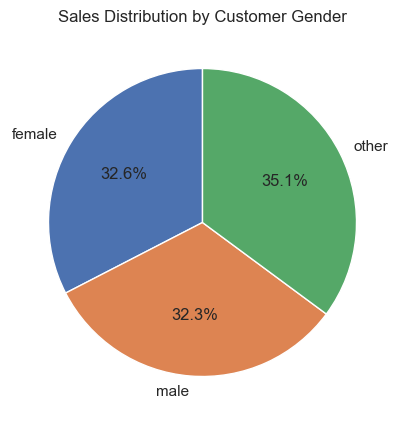

In [53]:
# Total sales by customer gender
gender_sales = sample3.groupby('customer_gender')['total_amount'].sum()

# Plotting sales by customer gender
plt.figure(figsize=(8, 5))
gender_sales.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Sales Distribution by Customer Gender')
plt.ylabel('')
plt.show()

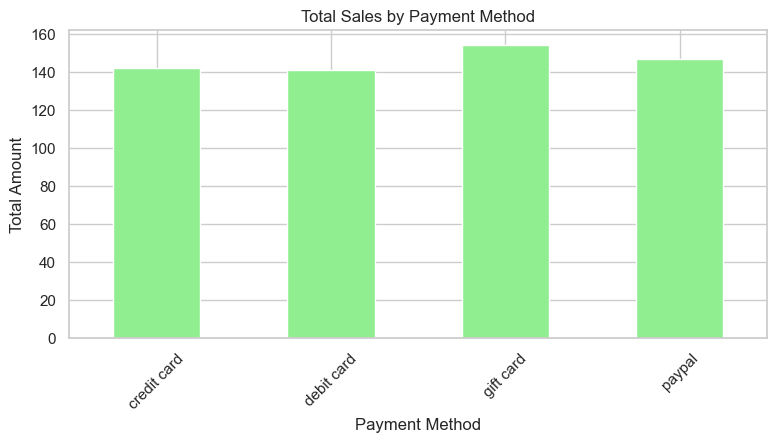

In [54]:
# Total sales by payment method
payment_sales = sample3.groupby('payment_method')['total_amount'].sum()

# Plotting payment method contributions
plt.figure(figsize=(9, 4))
payment_sales.plot(kind='bar', color='lightgreen')
plt.title('Total Sales by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Total Amount')
plt.xticks(rotation=45)
plt.show()


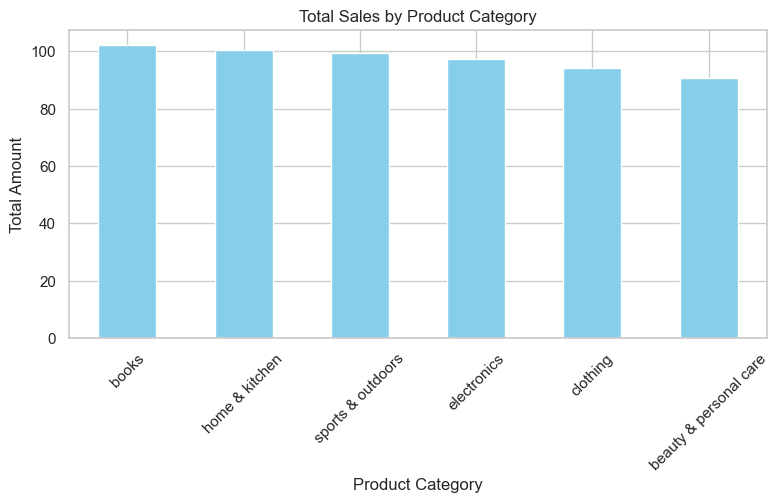

In [55]:
# Total sales by product category
category_sales = sample3.groupby('product_category')['total_amount'].sum().sort_values(ascending=False)

# Plotting sales by product category
plt.figure(figsize=(9, 4))
category_sales.plot(kind='bar', color='skyblue')
plt.title('Total Sales by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Total Amount')
plt.xticks(rotation=45)
plt.show()

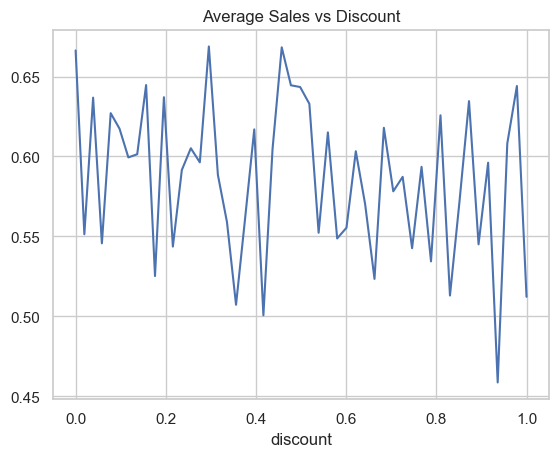

In [56]:
# Discount Impact: How discount affect sales
discount_effect = sample3.groupby('discount')['total_amount'].mean()
discount_effect.plot(title='Average Sales vs Discount')
plt.show()

payment_method
paypal         262
gift card      262
debit card     249
credit card    227
Name: count, dtype: int64


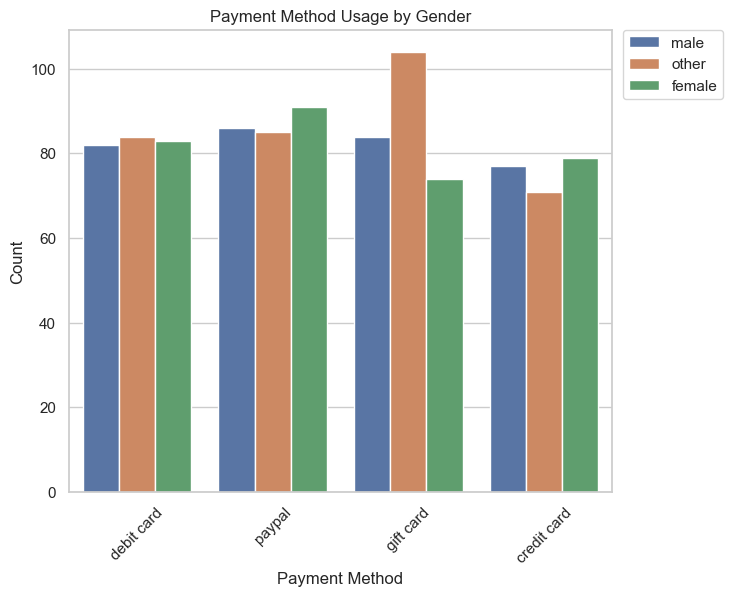

In [57]:
# Payment Analysis Concentration
# Payment Method Analysis: Understand which payment methods are preferred by customers.
# Customer Demographics by Payment Method
# Analyze how different payment methods are used across different customer segments gender

# Count of payment methods used by gender
payment_counts = sample3['payment_method'].value_counts()
print(payment_counts)
plt.figure(figsize=(7, 6))
sns.countplot(x='payment_method', hue='customer_gender', data=sample3)
plt.title('Payment Method Usage by Gender')
plt.xlabel('Payment Method')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

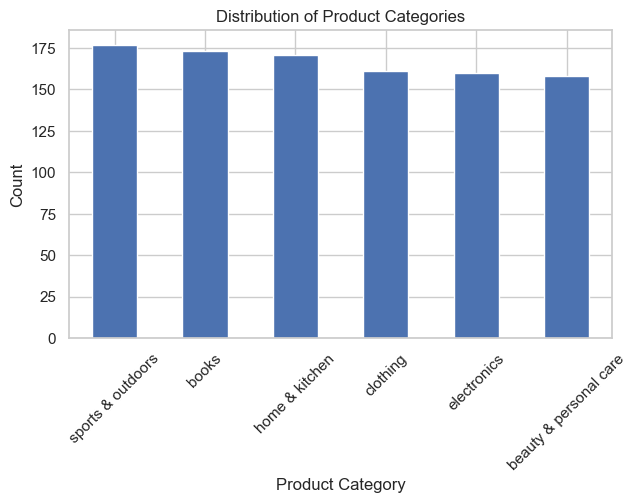

payment_method
paypal         262
gift card      262
debit card     249
credit card    227
Name: count, dtype: int64


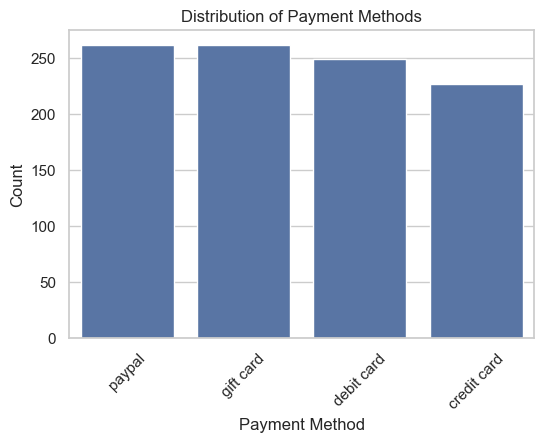

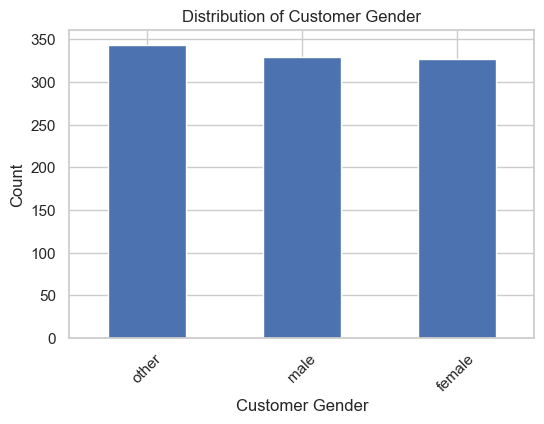

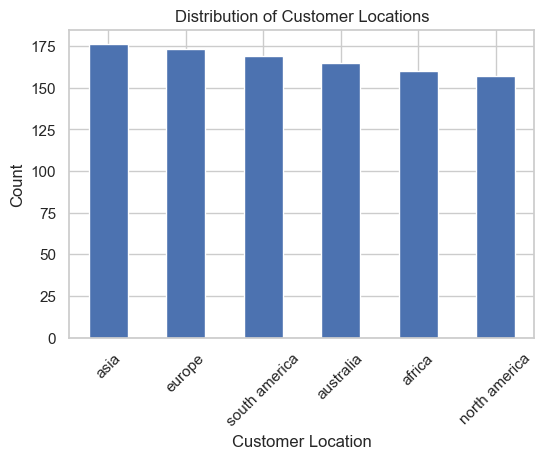

In [58]:
	
# 2. Explore the Categorical Columns
# Analyze the distribution of product categories
payment_counts = sample3['payment_method'].value_counts()

plt.figure(figsize=(7, 4))
sample3['product_category'].value_counts().plot(kind='bar')
plt.title('Distribution of Product Categories')
plt.xlabel('Product Category')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

# Analyze the distribution of payment methods
print(payment_counts)

plt.figure(figsize=(6, 4))
sns.countplot(x='payment_method', data=sample3, order=payment_counts.index)
plt.title('Distribution of Payment Methods')
plt.xlabel('Payment Method')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Analyze the distribution of customer gender
plt.figure(figsize=(6, 4))
sample3['customer_gender'].value_counts().plot(kind='bar')
plt.title('Distribution of Customer Gender')
plt.xlabel('Customer Gender')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Analyze the distribution of customer location
plt.figure(figsize=(6, 4))
sample3['customer_location'].value_counts().plot(kind='bar')
plt.title('Distribution of Customer Locations')
plt.xlabel('Customer Location')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

  payment_method  total_amount
0    credit card    142.268494
1     debit card    141.086385
2      gift card    154.584853
3         paypal    146.850553


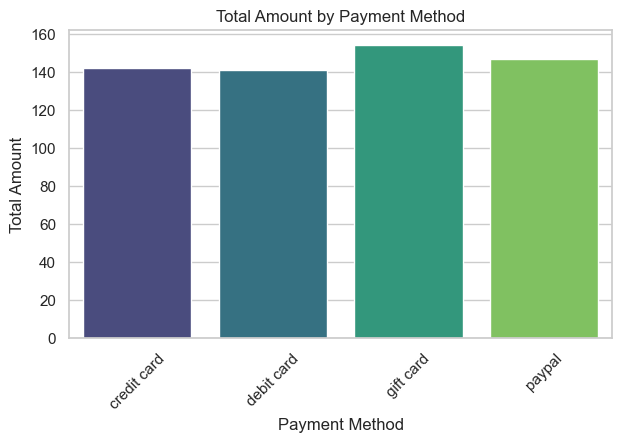

In [59]:
# Analyze Total Amount by Payment Method: Analyze the total sales amount for each payment method

total_amount_by_payment = sample3.groupby('payment_method')['total_amount'].sum().reset_index()
print(total_amount_by_payment)

# Visualize total amount by payment method
plt.figure(figsize=(7, 4))
sns.barplot(x='payment_method', y='total_amount', data=total_amount_by_payment, palette='viridis', hue='payment_method')
plt.title('Total Amount by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Total Amount')
plt.xticks(rotation=45)
plt.show()

  payment_method  total_amount
0    credit card    142.268494
1     debit card    141.086385
2      gift card    154.584853
3         paypal    146.850553


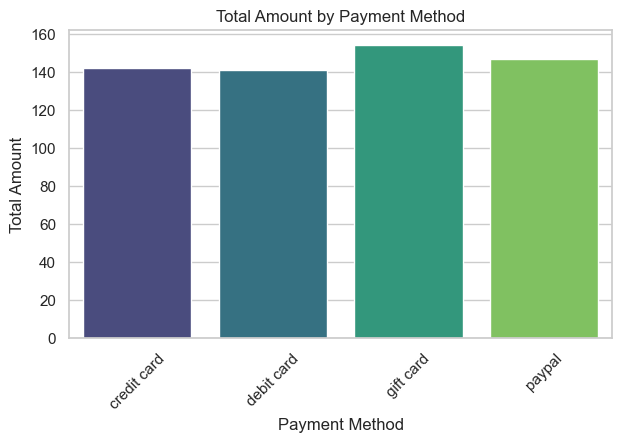

In [60]:
# Analyze Total Amount by Payment Method: Analyze the total sales amount for each payment method

total_amount_by_payment = sample3.groupby('payment_method')['total_amount'].sum().reset_index()
print(total_amount_by_payment)

# Visualize total amount by payment method
plt.figure(figsize=(7, 4))
sns.barplot(x='payment_method', y='total_amount', data=total_amount_by_payment, palette='viridis', hue='payment_method')
plt.title('Total Amount by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Total Amount')
plt.xticks(rotation=45)
plt.show()

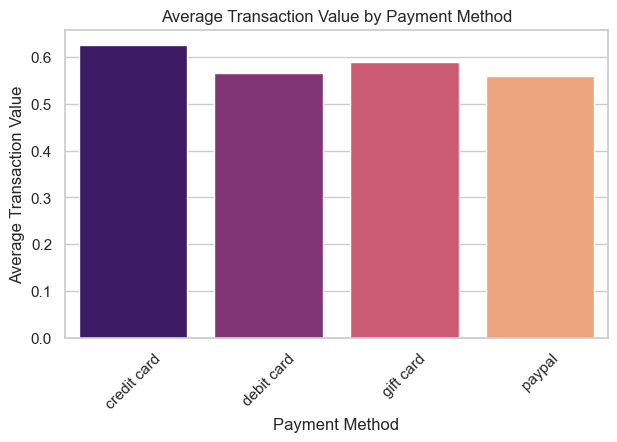

In [61]:
# Calculate and visualize the average transaction value for each payment method
# Average Transaction Value by Payment Method

avg_transaction_value = sample3.groupby('payment_method')['total_amount'].mean().reset_index()

# Visualize average transaction value by payment method
plt.figure(figsize=(7, 4))
sns.barplot(x='payment_method', y='total_amount', data=avg_transaction_value, palette='magma', hue='payment_method')
plt.title('Average Transaction Value by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Average Transaction Value')
plt.xticks(rotation=45)
plt.show()